# HTTP Log Parser

Because as far as I can tell, there isn't a good one that exists?

This Notebook ingests a given log file and produces useful statistics about the recorded traffic.

In [121]:
# Let's begin as we begin all good things, in the name of
import pandas as pd
import plotly.express as px
import altair as alt
import numpy
import re
# Allow Altair to handle large datasets
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [45]:
with open("samples/access.log") as f:
    raw_rows = [l.strip() for l in f.readlines()]

In [4]:
# Now we have to parse the row
# What's available?
# What do we care about?
# What lives where on the line?

'83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"'

In [43]:
def parse_row(row: str) -> dict:
    """
    Ingests a row of HTTP log and returns a dict with structured data
    """
    src_ip = re.search("^([0-9]{1,3}\.){3}[0-9]{1,3}", row)
    timestamp = re.search("\[(.+)\]", row)
    http_method = re.search("\] \"([A-Z]+) /", row)
    uri = re.search("[A-Z]+ (/.+) HTTP", row)
    http_status = re.search("HTTP/[12.]*\" ([0-9]{3}) ", row)
    response_size = re.search("[0-9]{3} ([0-9]+) \"", row)
    referrer = re.search("[0-9]+ \"(.*)\" \"", row)
    user_agent = re.search("\" \"(.+)\"", row)
    

    res = {
        "src_ip": src_ip.group(0) if src_ip else "",
        "timestamp": timestamp.group(1) if timestamp else "",
        "http_method": http_method.group(1) if http_method else "",
        "uri": uri.group(1) if uri else "",
        "http_status": http_status.group(1) if http_status else "",
        "response_size": response_size.group(1) if response_size else "",
        "referrer": referrer.group(1) if referrer else "",
        "user_agent": user_agent.group(1) if user_agent else "",
    }
    return res

In [47]:
# Use our row parser on each row
rows = list(map(parse_row, raw_rows))

In [50]:
# Load our data!
df = pd.DataFrame(rows)

In [53]:
# Make a proper datetime object
# Reference: 17/May/2015:10:05:03 +0000
df["_time"] = pd.to_datetime(df["timestamp"], format="%d/%b/%Y:%H:%M:%S %z")

## Exploratory Data Analysis

Learning the shape of our data

In [56]:
# How much stuff we got?
df.shape

(10000, 9)

In [58]:
# What stuff we got? Nice to have as a reference
df.columns

Index(['src_ip', 'timestamp', 'http_method', 'uri', 'http_status',
       'response_size', 'referrer', 'user_agent', '_time'],
      dtype='object')

### Top IP Addresses

In [72]:
# Group data by src_ip
df.groupby("src_ip").count().sort_values(by="timestamp", ascending=False)

,timestamp,http_method,uri,http_status,response_size,referrer,user_agent,_time
src_ip,,,,,,,,
66.249.73.135,482,482,482,482,482,482,482,482
46.105.14.53,364,364,364,364,364,364,364,364
130.237.218.86,357,357,357,357,357,357,357,357
75.97.9.59,273,273,273,273,273,273,273,273
50.16.19.13,113,113,113,113,113,113,113,113
...,...,...,...,...,...,...,...,...
41.249.219.90,1,1,1,1,1,1,1,1
41.99.29.14,1,1,1,1,1,1,1,1
42.156.136.43,1,1,1,1,1,1,1,1


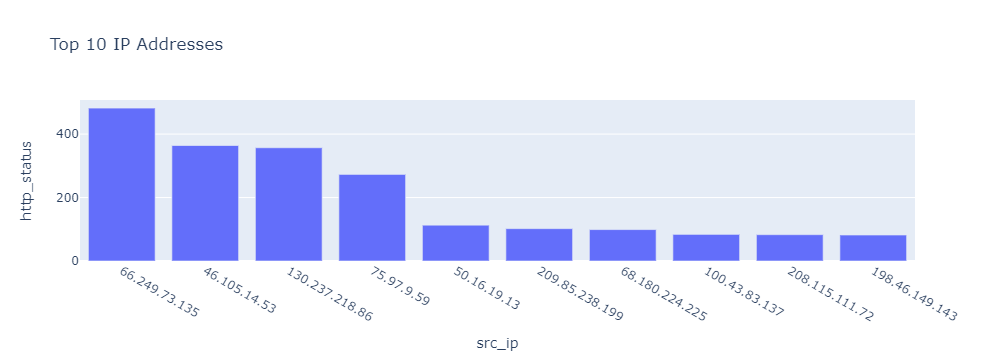

In [75]:
# Chart the top 10
top_10_ips = df.groupby("src_ip").count().sort_values(by="timestamp", ascending=False).head(10).reset_index()
px.bar(top_10_ips, x="src_ip", y="http_status", title="Top 10 IP Addresses")

### Top URIs


In [82]:
# Group data by URI
df.groupby("uri").count().sort_values(by="timestamp", ascending=False)

,src_ip,timestamp,http_method,http_status,response_size,referrer,user_agent,_time
uri,,,,,,,,
/favicon.ico,807,807,807,807,807,807,807,807
/style2.css,546,546,546,546,546,546,546,546
/reset.css,538,538,538,538,538,538,538,538
/images/jordan-80.png,533,533,533,533,533,533,533,533
/images/web/2009/banner.png,516,516,516,516,516,516,516,516
...,...,...,...,...,...,...,...,...
/blog/tags/testing,1,1,1,1,1,1,1,1
/blog/tags/tales-of-olden-time,1,1,1,1,1,1,1,1
/blog/tags/tail,1,1,1,1,1,1,1,1


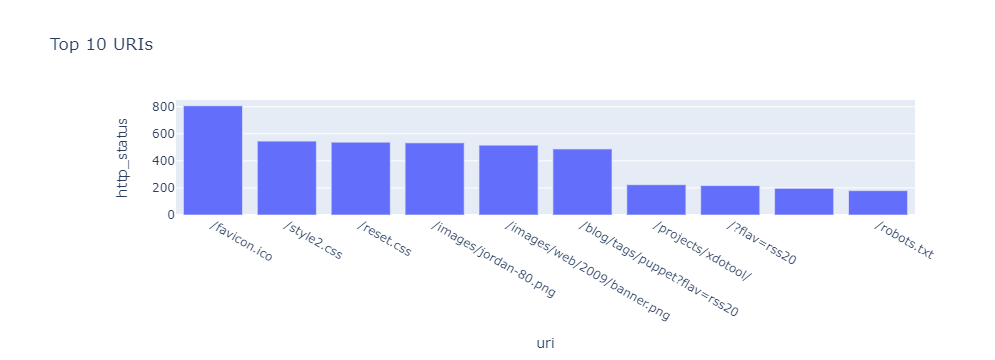

In [80]:
# Chart the top 10
top_10_uris = df.groupby("uri").count().sort_values(by="timestamp", ascending=False).head(10).reset_index()
px.bar(top_10_uris, x="uri", y="http_status", title="Top 10 URIs")

## Time Series Analysis

What happened when?

In [101]:
# Visits by top 10 IPs
top_10_visits = df[df.src_ip.apply(lambda i: i in top_10_ips.src_ip.values)]
top_10_visits.groupby(["src_ip","uri"]).count().head(100)

timestamp  \
src_ip         uri                                                             
100.43.83.137                                                              4   
               /?page=28                                                   1   
               /blog/geekery/102.html                                      1   
               /blog/geekery/interesting-freebsd-network-confi...          1   
               /blog/geekery/log-analytics-with-open-source.html           1   
...                                                                      ...   
130.237.218.86 /presentations/logstash-1/js/core.js                        3   
               /presentations/logstash-1/js/fg.menu.js                     3   
               /presentations/logstash-1/js/jTypeWriter.js                 3   
               /presentations/logstash-1/js/jquery-1.4.2.min.js            3   
               /presentations/logstash-1/js/jquery-print.js                3   

                                                                   http_method  \
src_ip         uri                                                               
100.43.83.137                                                                4   
               /?page=28                                                     1   
               /blog/geekery/102.html                                        1   
               /blog/geekery/interesting-freebsd-network-confi...            1   
               /blog/geekery/log-analytics-with-open-source.html             1   
...                                                                        ...   
130.237.218.86 /presentations/logstash-1/js/core.js                          3   
               /presentations/logstash-1/js/fg.menu.js                       3   
               /presentations/logstash-1/js/jTypeWriter.js                   3   
               /presentations/logstash-1/js/jquery-1.4.2.min.js              3   
               /presentations/logstash-1/js/jquery-print.js                  3   

                                                                   http_status  \
src_ip         uri                                                               
100.43.83.137                                                                4   
               /?page=28                                                     1   
               /blog/geekery/102.html                                        1   
               /blog/geekery/interesting-freebsd-network-confi...            1   
               /blog/geekery/log-analytics-with-open-source.html             1   
...                                                                        ...   
130.237.218.86 /presentations/logstash-1/js/core.js                          3   
               /presentations/logstash-1/js/fg.menu.js                       3   
               /presentations/logstash-1/js/jTypeWriter.js                   3   
               /presentations/logstash-1/js/jquery-1.4.2.min.js              3   
               /presentations/logstash-1/js/jquery-print.js                  3   

                                                                   response_size  \
src_ip         uri                                                                 
100.43.83.137                                                                  4   
               /?page=28                                                       1   
               /blog/geekery/102.html                                          1   
               /blog/geekery/interesting-freebsd-network-confi...              1   
               /blog/geekery/log-analytics-with-open-source.html               1   
...                                                                          ...   
130.237.218.86 /presentations/logstash-1/js/core.js                            3   
               /presentations/logstash-1/js/fg.menu.js                         3   
               /presentations/logstash-1/js/jTypeWri

In [130]:
alt.Chart(top_10_visits) \
.mark_line() \
.encode(x="_time:T", y="count(http_status):N", color="src_ip")

alt.Chart(...)

## Indicators of Attack

### Big Missers

Source IPs where the response was `401`, `403`, or `404`.

In [103]:
fails = ["404", "403", "401"]
fail_visits = df[df.http_status.apply(lambda s: s in fails)]

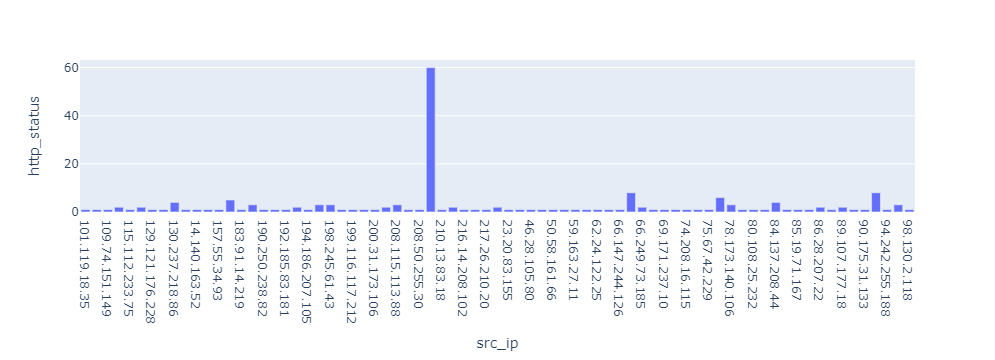

In [111]:
px.bar(fail_visits.groupby("src_ip").count().reset_index(), x="src_ip", y="http_status")

In [112]:
fail_visits.groupby("src_ip").count().sort_values(by="http_status", ascending=False)

,timestamp,http_method,uri,http_status,response_size,referrer,user_agent,_time
src_ip,,,,,,,,
208.91.156.11,60,60,60,60,60,60,60,60
66.249.73.135,8,8,8,8,8,8,8,8
91.236.75.25,8,8,8,8,8,8,8,8
75.97.9.59,6,6,6,6,6,6,6,6
176.92.75.62,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...
23.20.83.155,1,1,1,1,1,1,1,1
38.99.236.50,1,1,1,1,1,1,1,1
46.28.105.80,1,1,1,1,1,1,1,1


In [113]:
visits_208_91_156_11 = df[df.src_ip == "208.91.156.11"]

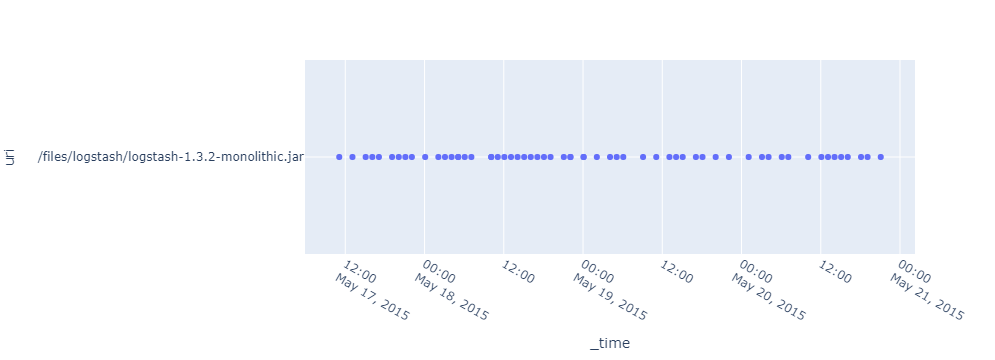

In [116]:
px.scatter(visits_208_91_156_11, x="_time", y="uri")